In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the file
!unzip /content/drive/MyDrive/trashClassifier/dataset-original.zip -d /content/trashnet

# Verify the folder structure
import os
data_dir = '/content/trashnet'
classes = os.listdir(data_dir)
print("Classes found:", classes)

Streaming output truncated to the last 5000 lines.
  inflating: /content/trashnet/dataset-original/cardboard/cardboard133.jpg  
  inflating: /content/trashnet/__MACOSX/dataset-original/cardboard/._cardboard133.jpg  
  inflating: /content/trashnet/dataset-original/cardboard/cardboard134.jpg  
  inflating: /content/trashnet/__MACOSX/dataset-original/cardboard/._cardboard134.jpg  
  inflating: /content/trashnet/dataset-original/cardboard/cardboard135.jpg  
  inflating: /content/trashnet/__MACOSX/dataset-original/cardboard/._cardboard135.jpg  
  inflating: /content/trashnet/dataset-original/cardboard/cardboard136.jpg  
  inflating: /content/trashnet/__MACOSX/dataset-original/cardboard/._cardboard136.jpg  
  inflating: /content/trashnet/dataset-original/cardboard/cardboard137.jpg  
  inflating: /content/trashnet/__MACOSX/dataset-original/cardboard/._cardboard137.jpg  
  inflating: /content/trashnet/dataset-original/cardboard/cardboard138.jpg  
  inflating: /content/trashnet/__MACOSX/dataset

In [ ]:
import os
from PIL import Image

# Path to dataset
dataset_path = '/content/trashnet/dataset-original'

# Check for corrupted images
corrupted_images = []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify image is not corrupted
            except (IOError, SyntaxError):
                corrupted_images.append(img_path)

# Report and remove corrupted images
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images. Removing them...")
    for corrupted_file in corrupted_images:
        os.remove(corrupted_file)
else:
    print("No corrupted images found!")


Found 5 corrupted images. Removing them...


In [ ]:
from PIL import Image

# Resize all images in the dataset to 128x128
IMG_HEIGHT, IMG_WIDTH = 128, 128

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                # Open, resize, and save the image
                img = Image.open(img_path)
                img = img.resize((IMG_WIDTH, IMG_HEIGHT))
                img.save(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("All images have been resized to 128x128 pixels.")


All images have been resized to 128x128 pixels.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Rotate the image by up to 30 degrees
    width_shift_range=0.2,  # Shift the image horizontally by up to 20% of width
    height_shift_range=0.2,  # Shift the image vertically by up to 20% of height
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out by up to 20%
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest'  # Fill any gaps created by transformations
)

print("Data augmentation setup is complete.")


Data augmentation setup is complete.


In [ ]:
# Define the dataset path
dataset_path = '/content/trashnet/dataset-original'

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32

# Training Data Generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Reserve 30% for validation and testing
)

# Validation Data Generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.3)

# Create Training and Validation Sets
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Testing Data Generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Ensure testing data is not shuffled
)

# Print Class Indices
print("Class Indices:", train_data.class_indices)


Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Class Indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Update ImageDataGenerator with preprocess_input for normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Standardize to ImageNet's mean/std
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Recreate data generators
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Pixel normalization to ImageNet mean and std completed.")


Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Pixel normalization to ImageNet mean and std completed.


In [ ]:
# Print sizes of the splits
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Testing samples: {test_data.samples}")

# Class indices
print(f"Class Indices: {train_data.class_indices}")


Training samples: 1771
Validation samples: 756
Testing samples: 2527
Class Indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening layer
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(6, activation='softmax')  # 6 classes
])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the CNN model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate can be tuned
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

print("Model compiled successfully.")


Model compiled successfully.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Updated file extension to .keras
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # You can increase if needed
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training complete.")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.2691 - loss: 18.8879 - val_accuracy: 0.2328 - val_loss: 1.7724
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.3174 - loss: 1.6456 - val_accuracy: 0.2672 - val_loss: 1.8241
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.3692 - loss: 1.5570 - val_accuracy: 0.3624 - val_loss: 1.5958
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.3666 - loss: 1.5734 - val_accuracy: 0.2937 - val_loss: 1.6549
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.3526 - loss: 1.6005 - val_accuracy: 0.3161 - val_loss: 1.6137
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.3661 - loss: 1.5087 - val_accuracy: 0.3320 - val_loss: 1.6135
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.3986 - loss: 1.4502 - val_accuracy: 0.3611 - val_loss: 1.5775
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.3960 - loss: 1.4525 - val_accuracy: 0.3638 - va

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6417 - loss: 1.0272
Test Accuracy: 0.5334
Test Loss: 1.1762


In [ ]:
# Save the model to a file
model.save("final_trashnet_model.keras")
print("Model saved as final_trashnet_model.keras")


Model saved as final_trashnet_model.keras


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Get test images and labels
test_images, test_labels = next(iter(test_data))

# Make predictions
predictions = model.predict(test_images)

# Convert predictions and labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Display a few results
for i in range(5):
    print(f"True Class: {true_classes[i]}, Predicted Class: {predicted_classes[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 1
True Class: 0, Predicted Class: 5
True Class: 0, Predicted Class: 0


In [ ]:
import os
from collections import Counter

# Count the number of images in each class
class_counts = Counter()
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print class counts
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Class Distribution:
paper: 594
plastic: 482
metal: 410
glass: 501
trash: 137
cardboard: 403


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Generate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Balances based on class distribution
    classes=np.unique(list(train_data.class_indices.values())),  # Class indices
    y=train_data.classes  # Training labels
)

# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0429917550058894, 1: 0.8409306742640076, 2: 1.0284552845528456, 3: 0.7095352564102564, 4: 0.8732741617357002, 5: 3.0746527777777777}


In [ ]:
# Train the model with class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Adjust if needed
    class_weight=class_weights_dict,  # Add class weights here
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with class weights complete.")


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.4969 - loss: 1.3238 - val_accuracy: 0.3849 - val_loss: 1.6742
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5041 - loss: 1.2767 - val_accuracy: 0.3968 - val_loss: 1.6299
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4892 - loss: 1.3455 - val_accuracy: 0.4021 - val_loss: 1.4538
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.4553 - loss: 1.3752 - val_accuracy: 0.4286 - val_loss: 1.4465
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.5182 - loss: 1.2178 - val_accuracy: 0.3770 - val_loss: 1.5376
Model retraining with class weights complete.


In [ ]:
# Define updated early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Retrain the model with updated early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Total epochs to allow more training
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with updated early stopping complete.")


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4927 - loss: 1.2416 - val_accuracy: 0.3585 - val_loss: 1.6631
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.4995 - loss: 1.3089 - val_accuracy: 0.4087 - val_loss: 1.4896
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4993 - loss: 1.3092 - val_accuracy: 0.4259 - val_loss: 1.4710
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5139 - loss: 1.2382 - val_accuracy: 0.4418 - val_loss: 1.4148
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.5276 - loss: 1.1789 - val_accuracy: 0.4048 - val_loss: 1.4523
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5182 - loss: 1.2172 - val_accuracy: 0.4167 - val_loss: 1.4915
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5377 - loss: 1.1633 - val_accuracy: 0.4365 - val_loss: 1.4285
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.5162 - loss: 1.2207 - val_accuracy: 0.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(6, activation='softmax')(x)  # Final output layer for 6 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate if necessary
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Retrain the transfer learning model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # You can adjust this if necessary
    class_weight=class_weights_dict,  # Use class weights to handle imbalance
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with transfer learning complete.")


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - accuracy: 0.4331 - loss: 1.8991 - val_accuracy: 0.6601 - val_loss: 0.8638
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7125 - loss: 0.7652 - val_accuracy: 0.7050 - val_loss: 0.7891
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.7490 - loss: 0.6923 - val_accuracy: 0.7434 - val_loss: 0.7189
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7810 - loss: 0.5935 - val_accuracy: 0.7394 - val_loss: 0.7263
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.8086 - loss: 0.5469 - val_accuracy: 0.7725 - val_loss: 0.6469
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8220 - loss: 0.4609 - val_accuracy: 0.7765 - val_loss: 0.6649
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.8148 - loss: 0.4979 - val_accuracy: 0.7672 - val_loss: 0.6406
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8399 - loss: 0.4321 - val_accuracy: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8978 - loss: 0.3138
Test Accuracy: 0.9046
Test Loss: 0.2769


In [ ]:
# Save the final trained model
model.save("final_trashnet_transfer_learning_model.keras")
print("Final model saved.")


Final model saved.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait for 3 epochs of no improvement
    min_lr=1e-6  # Minimum learning rate
)

# Retrain the model with ReduceLROnPlateau
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with learning rate scheduler complete.")


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8883 - loss: 0.3202 - val_accuracy: 0.7738 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.8697 - loss: 0.3475 - val_accuracy: 0.7923 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8726 - loss: 0.3437 - val_accuracy: 0.7923 - val_loss: 0.6010 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8724 - loss: 0.3745 - val_accuracy: 0.7870 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.8936 - loss: 0.2700 - val_accuracy: 0.7844 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8683 - loss: 0.3193 - val_accuracy: 0.7646 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.8954 - loss: 0.2823 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8659 - loss: 0.4462
Test Accuracy: 0.8864
Test Loss: 0.3388


In [ ]:
# Smaller batch size
BATCH_SIZE = 16

# Recreate data generators with smaller batch size
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Retrain the model
history_small_batch = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with smaller batch size complete.")


Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.8698 - loss: 0.3290 - val_accuracy: 0.7937 - val_loss: 0.6586 - learning_rate: 2.5000e-04
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8915 - loss: 0.2856 - val_accuracy: 0.8082 - val_loss: 0.6057 - learning_rate: 2.5000e-04
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8927 - loss: 0.2948 - val_accuracy: 0.8029 - val_loss: 0.6303 - learning_rate: 2.5000e-04
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8890 - loss: 0.2901 - val_accuracy: 0.8056 - val_loss: 0.6623 - learning_rate: 2.5000e-04
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8925 - loss: 0.2516 - val_accuracy: 0.7923 - val_loss: 0.7241 - learning_rate: 2.5000e-04
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9084 - loss: 0.2614 - val_accuracy: 0.7989 - val_loss: 0.6523 - learning_rate: 1.2500e-04
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8979 - loss: 0.3672
Test Accuracy: 0.9082
Test Loss: 0.2820


In [ ]:
model.save("final_trashnet_small_batch_model.keras")
print("Final model saved.")


Final model saved.


In [ ]:
# Larger batch size
BATCH_SIZE = 64

# Recreate data generators with larger batch size
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Retrain the model with the larger batch size
history_large_batch = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with larger batch size complete.")


Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - accuracy: 0.8850 - loss: 0.2933 - val_accuracy: 0.7937 - val_loss: 0.6563 - learning_rate: 6.2500e-05
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9013 - loss: 0.2579 - val_accuracy: 0.7923 - val_loss: 0.6513 - learning_rate: 6.2500e-05
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8924 - loss: 0.2556 - val_accuracy: 0.7910 - val_loss: 0.6477 - learning_rate: 6.2500e-05
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8836 - loss: 0.2846 - val_accuracy: 0.8003 - val_loss: 0.6397 - learning_rate: 6.2500e-05
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.8964 - loss: 0.2708 - val_accuracy: 0.8003 - val_loss: 0.6411 - learning_rate: 6.2500e-05
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9039 - loss: 0.2619 - val_accuracy: 0.8003 - val_loss: 0.6366 - learni

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8963 - loss: 0.3688
Test Accuracy: 0.9094
Test Loss: 0.2793


In [ ]:
model.save("final_trashnet_model_large_batch.keras")
print("Final model saved.")


Final model saved.


#5.5

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_lr = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, model_checkpoint]
    )
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Training with learning rate: 0.001
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.8683 - loss: 0.3529 - val_accuracy: 0.7540 - val_loss: 0.7264
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.8727 - loss: 0.3067 - val_accuracy: 0.7738 - val_loss: 0.6590
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8965 - loss: 0.2706 - val_accuracy: 0.7765 - val_loss: 0.6873
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9109 - loss: 0.2674 - val_accuracy: 0.7937 - val_loss: 0.7207
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9037 - loss: 0.2480 - val_accuracy: 0.7870 - val_loss: 0.7278
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9024 - loss: 0.2631 - val_accuracy: 0.7778 - val_loss: 0.7459
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8964 - loss: 0.2569 - val_accuracy: 0.7963 - val_loss: 0.6837
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.90

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_final = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Optimizer: {optimizer_name}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

model.save("final_trashnet_tuned_model.keras")
print("Final model saved.")


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.9204 - loss: 0.1975 - val_accuracy: 0.8056 - val_loss: 0.6942
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.9197 - loss: 0.2233 - val_accuracy: 0.8069 - val_loss: 0.6926
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9206 - loss: 0.2199 - val_accuracy: 0.8056 - val_loss: 0.6972
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.9173 - loss: 0.2165 - val_accuracy: 0.8082 - val_loss: 0.6682
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.9388 - loss: 0.1871 - val_accuracy: 0.8069 - val_loss: 0.6584
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.9076 - loss: 0.2300 - val_accuracy: 0.8095 - val_loss: 0.6545
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9110 - loss: 0.2058 - val_accuracy: 0.8095 - val_loss: 0.6551
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.9326 - loss: 0.1832 - val_accuracy: 0

#Optimizer Tuning

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop

# Define optimizers to test
optimizers = {
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
}

# Loop through optimizers
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {optimizer_name}")
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_optimizer = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, model_checkpoint]
    )
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Optimizer: {optimizer_name}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Training with optimizer: SGD
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.8974 - loss: 0.2909 - val_accuracy: 0.7804 - val_loss: 0.6906
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8970 - loss: 0.2574 - val_accuracy: 0.7725 - val_loss: 0.6920
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8877 - loss: 0.3042 - val_accuracy: 0.7632 - val_loss: 0.6538
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.8912 - loss: 0.2991 - val_accuracy: 0.7646 - val_loss: 0.6824
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8600 - loss: 0.3316 - val_accuracy: 0.7976 - val_loss: 0.6568
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8737 - loss: 0.3221 - val_accuracy: 0.7989 - val_loss: 0.6987
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.9179 - loss: 0.2245 - val_accuracy: 0.8082 - val_loss: 0.6180
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.8824 - l

In [ ]:
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_final_sgd = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Optimizer: {optimizer_name}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
model.save("final_trashnet_sgd_model.keras")
print("Final model saved with SGD optimizer.")

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - accuracy: 0.9111 - loss: 0.2255 - val_accuracy: 0.7976 - val_loss: 0.6779
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.8910 - loss: 0.2847 - val_accuracy: 0.7751 - val_loss: 0.7333
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.8861 - loss: 0.2764 - val_accuracy: 0.7646 - val_loss: 0.7191
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9052 - loss: 0.2644 - val_accuracy: 0.7778 - val_loss: 0.7706
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.9030 - loss: 0.2502 - val_accuracy: 0.7923 - val_loss: 0.7155
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8901 - loss: 0.2822 - val_accuracy: 0.8029 - val_loss: 0.6993
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9011 - loss: 0.2338 - val_accuracy: 0.8042 - val_loss: 0.6698
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9212 - loss: 0.2140 - val_accuracy: 0

#Performance Metrics

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.93      0.96       403
       glass       0.91      0.91      0.91       501
       metal       0.91      0.90      0.90       410
       paper       0.95      0.96      0.95       594
     plastic       0.91      0.89      0.90       482
       trash       0.69      0.90      0.78       137

    accuracy                           0.92      2527
   macro avg       0.89      0.91      0.90      2527
weighted avg       0.92      0.92      0.92      2527



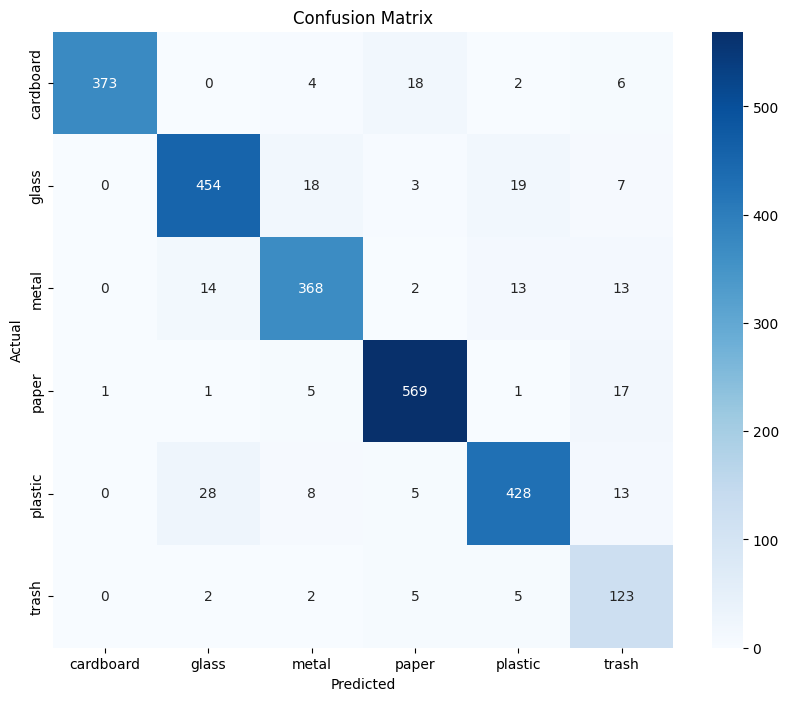

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
true_labels = test_data.classes  # Ground truth
predictions = model.predict(test_data, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute classification metrics
class_names = list(test_data.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


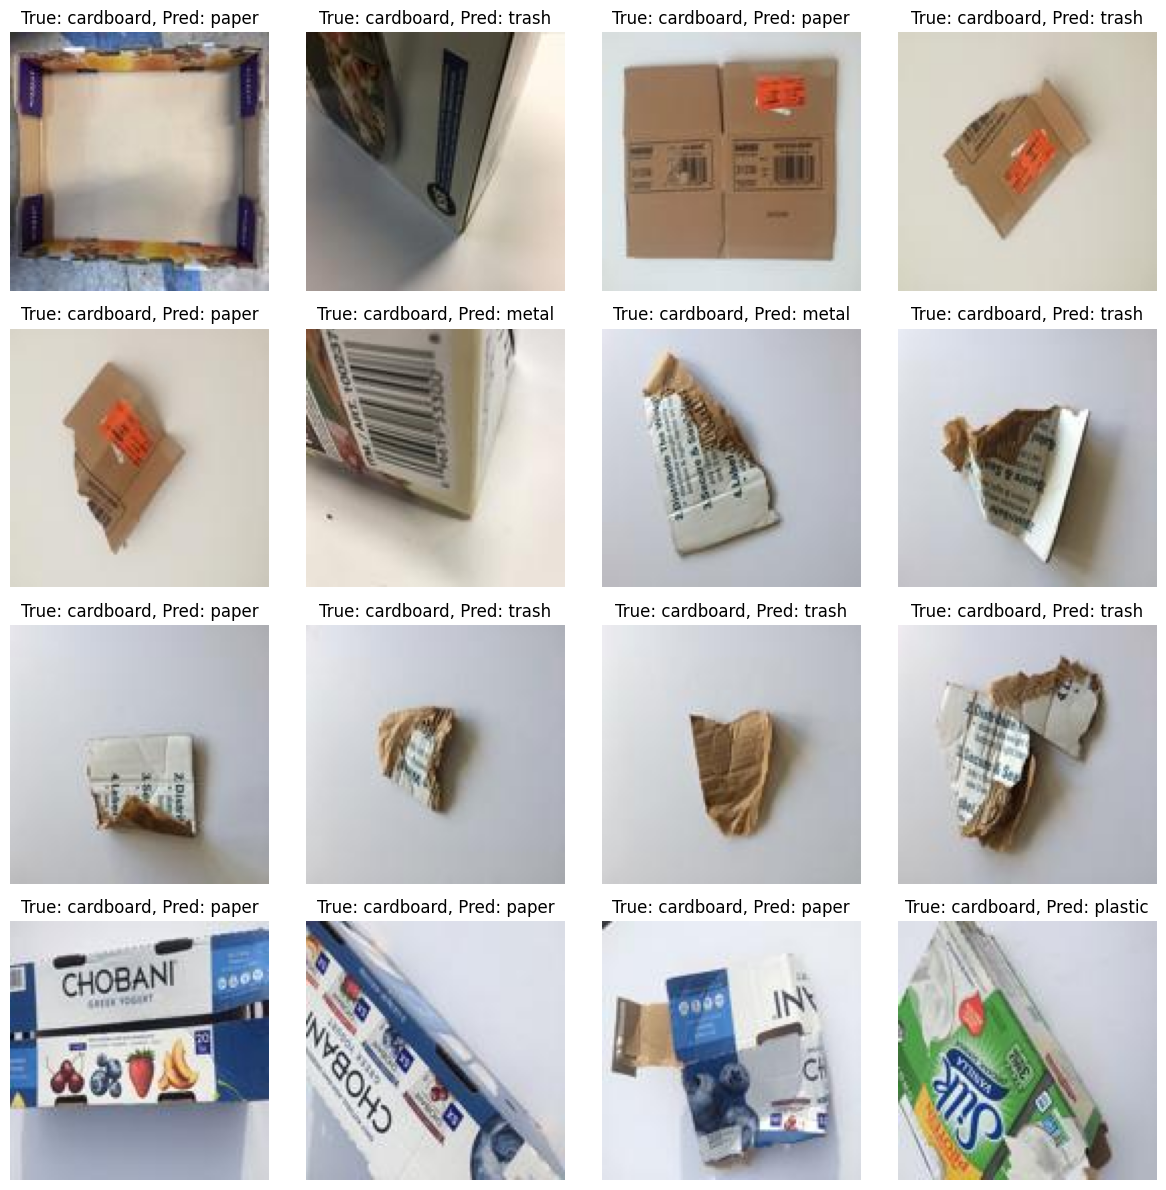

In [ ]:
# Visualize misclassified images
import matplotlib.pyplot as plt

misclassified_indices = np.where(true_labels != predicted_labels)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:16]):  # Show up to 16 examples
    plt.subplot(4, 4, i + 1)
    img = test_data.filepaths[idx]
    img_array = plt.imread(img)
    plt.imshow(img_array)
    plt.title(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[predicted_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


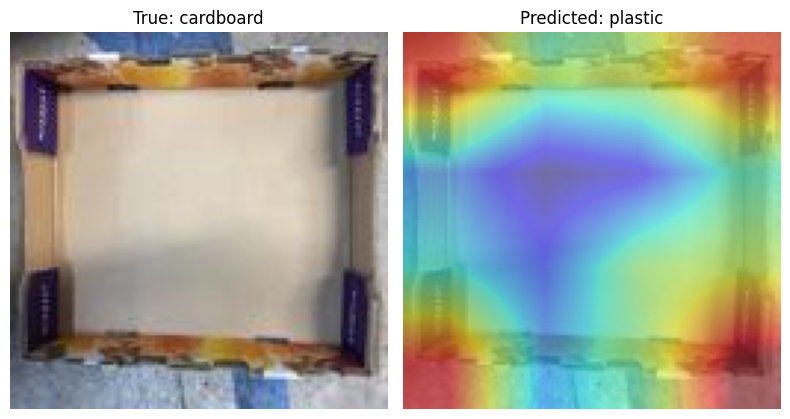

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


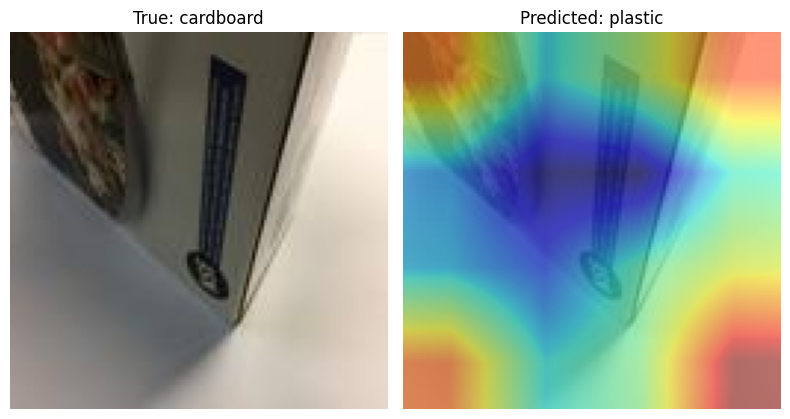

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


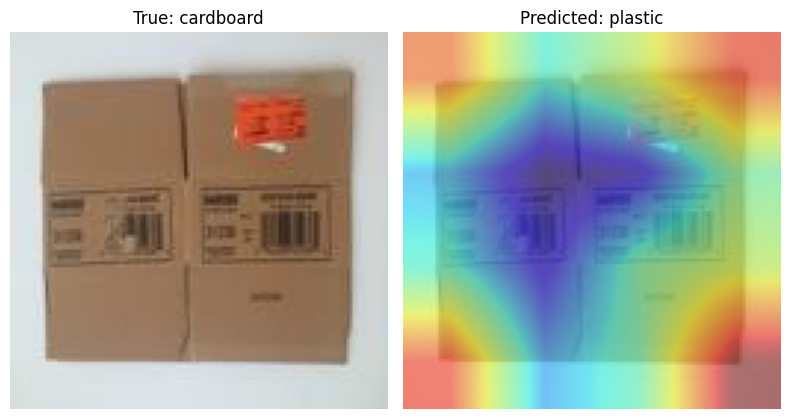

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


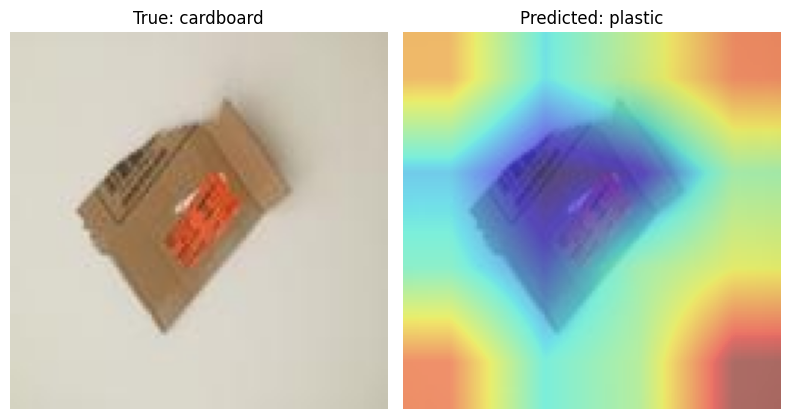

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


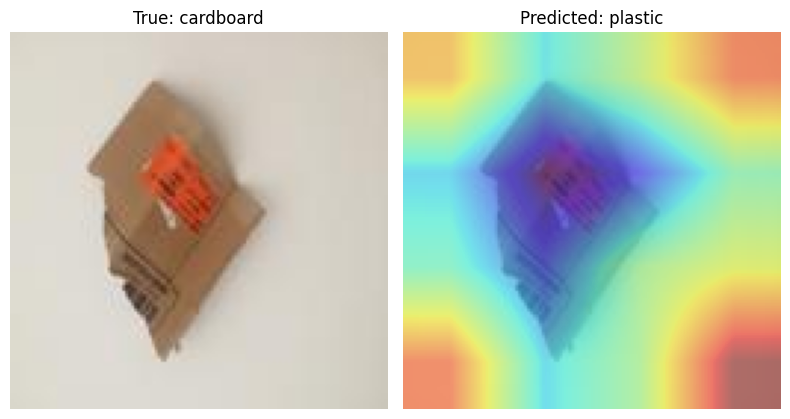

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

# Define a function to generate CAMs
def generate_cam(model, image, true_label, class_names):
    # Identify the last convolutional layer
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that outputs the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Preprocess the image
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img / 255.0, axis=0)  # Normalize and expand dimensions

    # Get the feature maps and predictions
    feature_maps, predictions = cam_model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Get weights of the last dense layer
    weights = model.layers[-1].weights[0].numpy()  # Shape: (num_filters, num_classes)

    # Compute the weighted sum of the feature maps
    cam = np.zeros(feature_maps[0].shape[:2], dtype=np.float32)  # Initialize CAM
    for i, w in enumerate(weights[:, predicted_class]):  # Loop through all filters
        cam += w * feature_maps[0][:, :, i]  # Weighted sum

    # Normalize CAM
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))  # Resize to original image size
    cam = np.maximum(cam, 0)  # ReLU (only positive activations)
    if cam.max() > 0:
      cam = cam / cam.max()  # Normalize to 0-1
    else:
      cam = np.zeros_like(cam)  # Default to zeros if no activation


    return cam, predicted_class


# Plot the CAM overlaid on the original image
def plot_cam(image, cam, true_label, predicted_label, class_names):
    plt.figure(figsize=(8, 8))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Overlay CAM
    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay CAM
    plt.title(f"Predicted: {class_names[predicted_label]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate CAMs for misclassified images
for idx in misclassified_indices[:5]:  # Visualize first 5 misclassified images
    img_path = test_data.filepaths[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cam, pred_class = generate_cam(model, img, true_labels[idx], class_names)
    plot_cam(img, cam, true_labels[idx], pred_class, class_names)


#More Epochs

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Use the previously configured SGD optimizer
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model (reusing the SGD configuration)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Early stopping patience
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Reduce LR if no improvement for 5 epochs
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    'best_model_sgd_extended.keras',
    save_best_only=True,
    monitor='val_loss'
)

# Train the model with extended epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Increase epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - accuracy: 0.9016 - loss: 0.2768 - val_accuracy: 0.8095 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9083 - loss: 0.2345 - val_accuracy: 0.8135 - val_loss: 0.6434 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9226 - loss: 0.2104 - val_accuracy: 0.8161 - val_loss: 0.6557 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.9210 - loss: 0.1984 - val_accuracy: 0.8108 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.9152 - loss: 0.2110 - val_accuracy: 0.8122 - val_loss: 0.6592 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9354 - loss: 0.1706 - val_accuracy: 0.8135 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9184 - loss: 0.2429 -

In [ ]:
model.save('final_model_sgd_extended.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


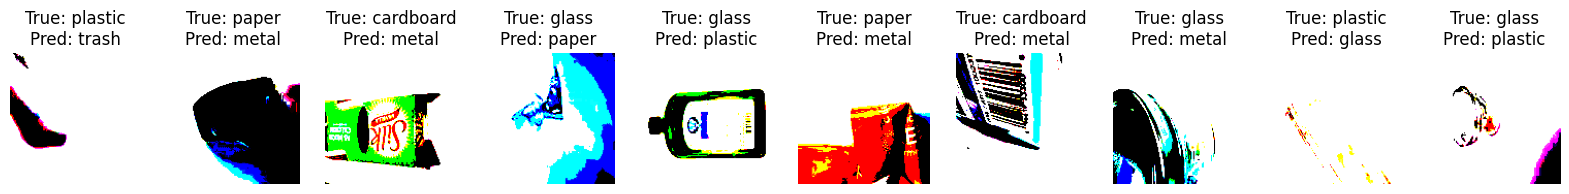

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified_images(model, data_generator, class_names, num_samples=20):
    """Display a few misclassified images."""
    misclassified_images = []
    true_labels = []
    pred_labels = []

    for i in range(len(data_generator)):
        images, labels = next(data_generator)
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        for j in range(len(images)):
            if true_classes[j] != predicted_classes[j]:
                misclassified_images.append(images[j])
                true_labels.append(true_classes[j])
                pred_labels.append(predicted_classes[j])

            if len(misclassified_images) >= num_samples:
                break
        if len(misclassified_images) >= num_samples:
            break

    # Plot the misclassified images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for i in range(len(misclassified_images)):
        ax = axes[i]
        ax.imshow(misclassified_images[i])
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        ax.axis("off")

# Ensure the validation data generator is used correctly
show_misclassified_images(
    model=model,
    data_generator=val_data,  # Correctly use your validation data
    class_names=list(train_data.class_indices.keys()),  # Class names from generator
    num_samples=10
)


In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

# Train the model with the computed class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Use early stopping as needed
    class_weight=class_weights_dict,  # Pass computed class weights
    callbacks=[early_stopping, reduce_lr]  # Ensure callbacks are defined
)


Class Weights: {0: 1.0429917550058894, 1: 0.8409306742640076, 2: 1.0284552845528456, 3: 0.7095352564102564, 4: 0.8732741617357002, 5: 3.0746527777777777}
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.9267 - loss: 0.2322 - val_accuracy: 0.8095 - val_loss: 0.6463 - learning_rate: 2.5000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9183 - loss: 0.2398 - val_accuracy: 0.8082 - val_loss: 0.6496 - learning_rate: 2.5000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.9101 - loss: 0.2122 - val_accuracy: 0.8056 - val_loss: 0.6537 - learning_rate: 2.5000e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9138 - loss: 0.2059 - val_accuracy: 0.8056 - val_loss: 0.6556 - learning_rate: 2.5000e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.9175 - loss: 0.2193 - val_accuracy: 0.8056 - val_loss: 0.6560 - learning_rate: 2.5000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9092 - loss: 0.3267
Test Accuracy: 0.9248, Test Loss: 0.2491


In [ ]:
model.save('final_model_finetuned_classweights.keras')

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.9271 - loss: 0.1947 - val_accuracy: 0.8122 - val_loss: 0.6487 - learning_rate: 1.2500e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9078 - loss: 0.2404 - val_accuracy: 0.8122 - val_loss: 0.6490 - learning_rate: 1.2500e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9223 - loss: 0.2116 - val_accuracy: 0.8108 - val_loss: 0.6505 - learning_rate: 1.2500e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.9341 - loss: 0.1862 - val_accuracy: 0.8122 - val_loss: 0.6520 - learning_rate: 1.2500e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.9161 - loss: 0.2277 - val_accuracy: 0.8135 - val_loss: 0.6527 - learning_rate: 1.2500e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9155 - loss: 0.2289
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9156

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9094 - loss: 0.3305
Test Accuracy: 0.9256, Test Loss: 0.2498


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Lower reduction factor
    patience=10,  # More patience
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # You can increase this if necessary
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.9141 - loss: 0.2178 - val_accuracy: 0.8016 - val_loss: 0.6950 - learning_rate: 1.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9281 - loss: 0.2022 - val_accuracy: 0.8082 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.9224 - loss: 0.2249 - val_accuracy: 0.8082 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.9252 - loss: 0.2016 - val_accuracy: 0.8148 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.9146 - loss: 0.2506 - val_accuracy: 0.8122 - val_loss: 0.6687 - learning_rate: 1.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9238 - loss: 0.1961 - val_accuracy: 0.8069 - val_loss: 0.6552 - learning_rate: 1.0000e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy:

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9126 - loss: 0.3480
Test Accuracy: 0.9244, Test Loss: 0.2588


In [ ]:
model.save('final_model_finetuned_classweights_reducedlr.keras')

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Recompute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

print(f"Updated Class Weights: {class_weights}")

# Train with updated weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)


Updated Class Weights: {0: 1.0429917550058894, 1: 0.8409306742640076, 2: 1.0284552845528456, 3: 0.7095352564102564, 4: 0.8732741617357002, 5: 3.0746527777777777}
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.9168 - loss: 0.2426 - val_accuracy: 0.8029 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9239 - loss: 0.2216 - val_accuracy: 0.8003 - val_loss: 0.6766 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9223 - loss: 0.2554 - val_accuracy: 0.7910 - val_loss: 0.6694 - learning_rate: 1.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9284 - loss: 0.1924 - val_accuracy: 0.7937 - val_loss: 0.6748 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.9273 - loss: 0.1746 - val_accuracy: 0.8016 - val_loss: 0.6553 - learning_rate: 1.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accu

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9150 - loss: 0.3350
Test Accuracy: 0.9240, Test Loss: 0.2546


In [ ]:
model.save('final_model_finetuned_classweights_reducedlr_updated.keras')